In [1]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, execute, transpile, assemble, QuantumRegister, ClassicalRegister
from qiskit.visualization import plot_histogram


In [3]:
def binary(num,length): #converts an integer to a binary number with defined length
    b = bin(num)[2:]
    return "0"*(length-len(b))+str(b)

7


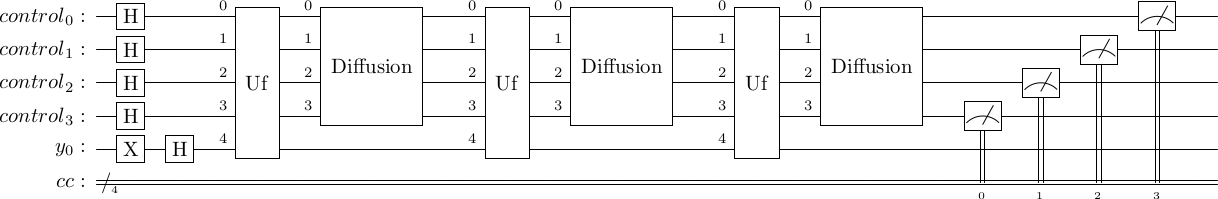

In [4]:
ncon = 4
controlreg = QuantumRegister(ncon,"control")
hreg  = QuantumRegister(1,"y")
cc = ClassicalRegister(ncon,"cc")
#xi = np.random.randint(0,2**ncon-1) #xi as in the greek letter
xi = 7

R = int(np.pi/4*np.sqrt(2**ncon))

qc = QuantumCircuit(controlreg,hreg,cc)

def Uf(controlreg,hreg,xi,ncon): #the oracle gate, a multi=controlled x gate which is one iff the input = xi
    hcirc = QuantumCircuit(hreg)
    circ = QuantumCircuit(controlreg,hreg)
    xiBin = binary(xi,ncon)
    zerolist = [i for i in range(ncon) if (xiBin[i] == "0")]
    circ.x(zerolist)
    circ.mct(list(range(ncon)),ncon)
    circ.x(zerolist)
    circ.name = "Uf"
    return circ


def ccz(controls=2): #multi controlled Z gate (decomposed here as a multi controlled X with H gates placed either side)
    circ = QuantumCircuit(controls+1)
    circ.h(controls)
    circ.mct(list(range(controls)),[controls])
    circ.h(controls)
    circ.name = "c"*controls+"z"
    return circ

def diffusion(ncon): #https://rdcu.be/cLzsq
    circ = QuantumCircuit(ncon)
    circ.h(range(ncon))
    circ.x(range(ncon))
    circ.append(ccz(ncon-1),list(range(ncon)))
    circ.barrier()
    circ.x(range(ncon))
    circ.h(range(ncon))
    circ.name = "Diffusion"
    return circ

Ufgate = Uf(controlreg,hreg,xi,ncon)

qc.x(hreg[0])
qc.h(hreg[0]) 
qc.h(range(ncon))

for e in range(R):
    qc.barrier()
    qc.append(Ufgate,controlreg[:]+hreg[:])
    qc.barrier()
    qc.append(diffusion(ncon).decompose(),controlreg[:ncon])
    qc.barrier()

qc.measure([controlreg[i] for i in range(ncon-1,-1,-1)],cc,)
print(xi)
qc.draw(plot_barriers=False,fold = -1,output = "latex")


In [5]:
?aersim

Object `aersim` not found.


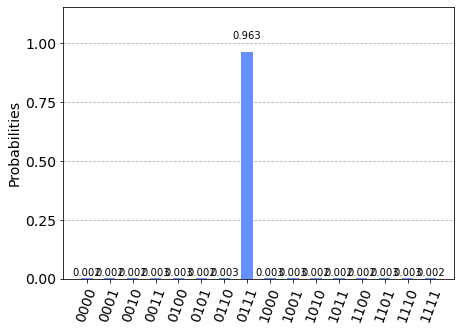

In [6]:
aersim = Aer.get_backend('aer_simulator') #set memory=True to see measurements
tqc = transpile(qc,aersim)
results = aersim.run(tqc,shots=10000).result()
plot_histogram(results.get_counts())

<BarContainer object of 15 artists>

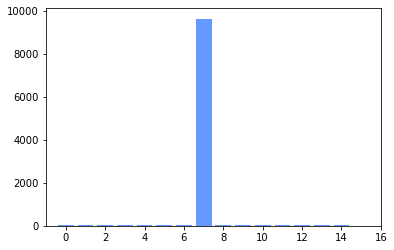

In [7]:
aersim = Aer.get_backend('aer_simulator') #set memory=True to see measurements
tqc = transpile(qc,aersim)
results = aersim.run(tqc,shots=10000).result()
d = results.get_counts()
oldkeys = list(d.keys())
for key in oldkeys:
    d[str(int(key,2))] = d[key]
    del d[key]
x = np.arange(0,2**ncon-1,1)
y = np.zeros(len(x))
for i,xi in enumerate(x):
    if str(xi) in d.keys():
        y[i] = d[str(xi)]
plt.xlim(-1,2**ncon)
plt.bar(x,y,color=(0.4,0.6,1))


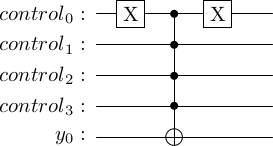

In [15]:
controlreg,hreg = QuantumRegister(4,"control"),QuantumRegister(1,"y")
xi = 7
hcirc = QuantumCircuit(hreg)
circ = QuantumCircuit(controlreg,hreg)
xiBin = binary(xi,ncon)
zerolist = [i for i in range(ncon) if (xiBin[i] == "0")]
circ.x(zerolist)
circ.mct(list(range(ncon)),ncon)
circ.x(zerolist)
circ.name = "Uf"
circ.draw(output="latex")

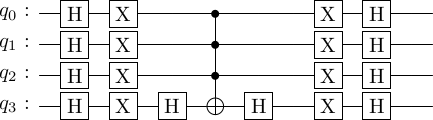

In [21]:
circ = QuantumCircuit(ncon)
circ.h(range(ncon))
circ.x(range(ncon))
circ.h(ncon-1)
circ.mct(list(range(ncon-1)),[ncon-1])
circ.h(ncon-1)
circ.barrier()
circ.x(range(ncon))
circ.h(range(ncon))

circ.name = "Diffusion"
circ.draw(output="latex",plot_barriers=False)

{'0': 707, '1': 543, '2': 667, '3': 603, '4': 581, '5': 437, '6': 628, '7': 562, '8': 833, '9': 628, '10': 755, '11': 634, '12': 670, '13': 518, '14': 646, '15': 588}


Text(0.5, 0, 'x')

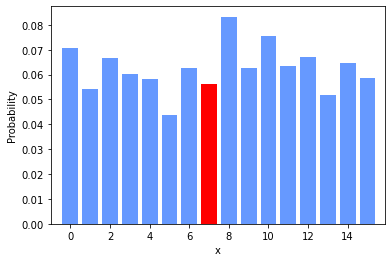

In [2]:
from qiskit import IBMQ
IBMQ.enable_account("")         
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = provider.get_backend("ibmq_quito")
res = backend.retrieve_job("622a012c9e029c54a90deedc").result()
plot_histogram(res.get_counts())

nbits = 4
d = res.get_counts()
oldkeys = list(d.keys())
for key in oldkeys:
    d[str(int(key,2))] = d[key]
    del d[key]
x = list(range(0,7))+list(range(8,16))
xi, yi = 7,d["7"]/10000
del d["7"]
y = [d[str(xi)]/10000 for xi in x]
plt.xlim(-1,15.9)
plt.bar(x,y,color=(0.4,0.6,1))
plt.bar(xi,yi,color=(1,0,0))
plt.ylabel("Probability")
plt.xlabel("x")